In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
space = ExpressionSpace.from_config(get_path('configs', 'v7.0', 'expression_space.yaml'))

In [3]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [4]:
MODELS = [
    # 'v7.0-mini',
    # 'v7.0-large',

    'v7.0',
    'v7.2',
    'v7.11',

    'analysis_beams_v7.0/v7.0_1-beams',
    'analysis_beams_v7.2/v7.2_1-beams',
    'analysis_beams_v7.11/v7.11_1-beams',

    'analysis_beams_v7.0/v7.0_512-beams',
    'analysis_beams_v7.2/v7.2_512-beams',
    'analysis_beams_v7.11/v7.11_512-beams',
]
MODELS_DESCRIPTION = {
    'nesymres-100M': 'NeSymReS 100M',
    'pysr': 'PySR',
}

for model in MODELS:
    if model.startswith('analysis_beams_'):
        MODELS_DESCRIPTION[model] = model.split('/')[1]
    elif model not in MODELS_DESCRIPTION:
        MODELS_DESCRIPTION[model] = model

In [5]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool-15',
}
TEST_SET_TITLES_LONG = {
    'train': 'Train',
    'val': 'Validation',
    'feynman': 'Feynman',
    'soose_nc': 'SOOSE-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool-15',
}

In [6]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [7]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [8]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [9]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y'])

            for k in keys_to_remove:
                del test_set_results['data'][k]

Loading analysis_beams_v7.2/v7.2_1-beams results: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
Loading analysis_beams_v7.11/v7.11_1-beams results: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]
Loading analysis_beams_v7.0/v7.0_512-beams results: 100%|██████████| 4/4 [04:29<00:00, 67.34s/it]
Loading analysis_beams_v7.2/v7.2_512-beams results: 100%|██████████| 2/2 [02:12<00:00, 66.20s/it]
Loading analysis_beams_v7.11/v7.11_512-beams results: 100%|██████████| 1/1 [01:06<00:00, 66.97s/it]


In [10]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            if 'beam_search_time' not in data:
                results[model][test_set]['data']['wall_time'] = data['fit_time']
                results[model][test_set]['data']['sys_time'] = data['fit_time']
                continue
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]


In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']
        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])

        for j in range(beam_width):
            if f'free_beam_{j + 1}' in data:
                results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])
            if f'residuals_beam_{j + 1}' in data:
                results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


In [12]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


In [13]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        for maybe_val in ['']:# , '_val'
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([np.log10(max(1 - r2, np.finfo(np.float32).eps)) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [14]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'fit_time',  'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam', 'y_noisy'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'is_finite',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_recall_best_beam',
 'structural_accuracy_best_beam',
 'sys_time',
 'tree_edit_distance_best_beam',
 'wall_time'}

In [15]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [16]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [17]:
from functools import partial

In [18]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

In [19]:
N_BOOTSTRAPS = 1_000

In [20]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

v7.0 train:  10%|▉         | 4/42 [00:01<00:15,  2.48it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams_v7.0/v7.0_1-beams soose_nc:  76%|███████▌  | 32/42 [00:03<00:01,  8.71it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
analysis_beams_v7.11/v7.11_512-beams pool_15: 100%|██████████| 42/42 [00:04<00:00,  9.15it/s]


# Length

In [21]:
data_lengths = {model: {test_set: None for test_set in TEST_SETS} for model in array_dfs.keys()}

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        if len(model_dfs) == 0:
            continue
        data_lengths[model][test_set] = {length: df[df['length_target'] == length] for length in range(32)}

In [22]:
fvu_at_lengths = {}

for model, model_dfs in array_dfs.items():
    fvu_at_lengths[model] = {}
    for test_set, df in model_dfs.items():
            print(f'{model} {test_set}')
            # Draw the median FVU for each length
            bootstraps = [bootstrapped_metric_ci(data_lengths[model][test_set][length]['fvu'].values + np.finfo(np.float64).eps, np.nanmedian, n=N_BOOTSTRAPS) for length in range(2, 32)]
            median = [b[0] for b in bootstraps]
            lower = [b[1] for b in bootstraps]
            upper = [b[2] for b in bootstraps]

            valid_mask = ~np.isnan(median)

            fvu_at_lengths[model][test_set] = {
                'index': np.arange(2, 32)[valid_mask],
                'median': np.array(median)[valid_mask],
                'lower': np.array(lower)[valid_mask],
                'upper': np.array(upper)[valid_mask],
            }

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


v7.0 train
v7.0 val
v7.0 feynman
v7.0 soose_nc
v7.0 nguyen
v7.0 pool_15
v7.2 train
v7.2 val
v7.2 feynman
v7.2 soose_nc
v7.2 nguyen
v7.2 pool_15
v7.11 train
v7.11 val
v7.11 feynman
v7.11 soose_nc
v7.11 nguyen
v7.11 pool_15
analysis_beams_v7.0/v7.0_1-beams feynman
analysis_beams_v7.0/v7.0_1-beams soose_nc
analysis_beams_v7.0/v7.0_1-beams nguyen
analysis_beams_v7.0/v7.0_1-beams pool_15
analysis_beams_v7.2/v7.2_1-beams pool_15
analysis_beams_v7.11/v7.11_1-beams pool_15
analysis_beams_v7.0/v7.0_512-beams feynman
analysis_beams_v7.0/v7.0_512-beams soose_nc
analysis_beams_v7.0/v7.0_512-beams nguyen
analysis_beams_v7.0/v7.0_512-beams pool_15
analysis_beams_v7.2/v7.2_512-beams soose_nc
analysis_beams_v7.2/v7.2_512-beams pool_15
analysis_beams_v7.11/v7.11_512-beams pool_15


/tmp/ipykernel_29484/3624457131.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


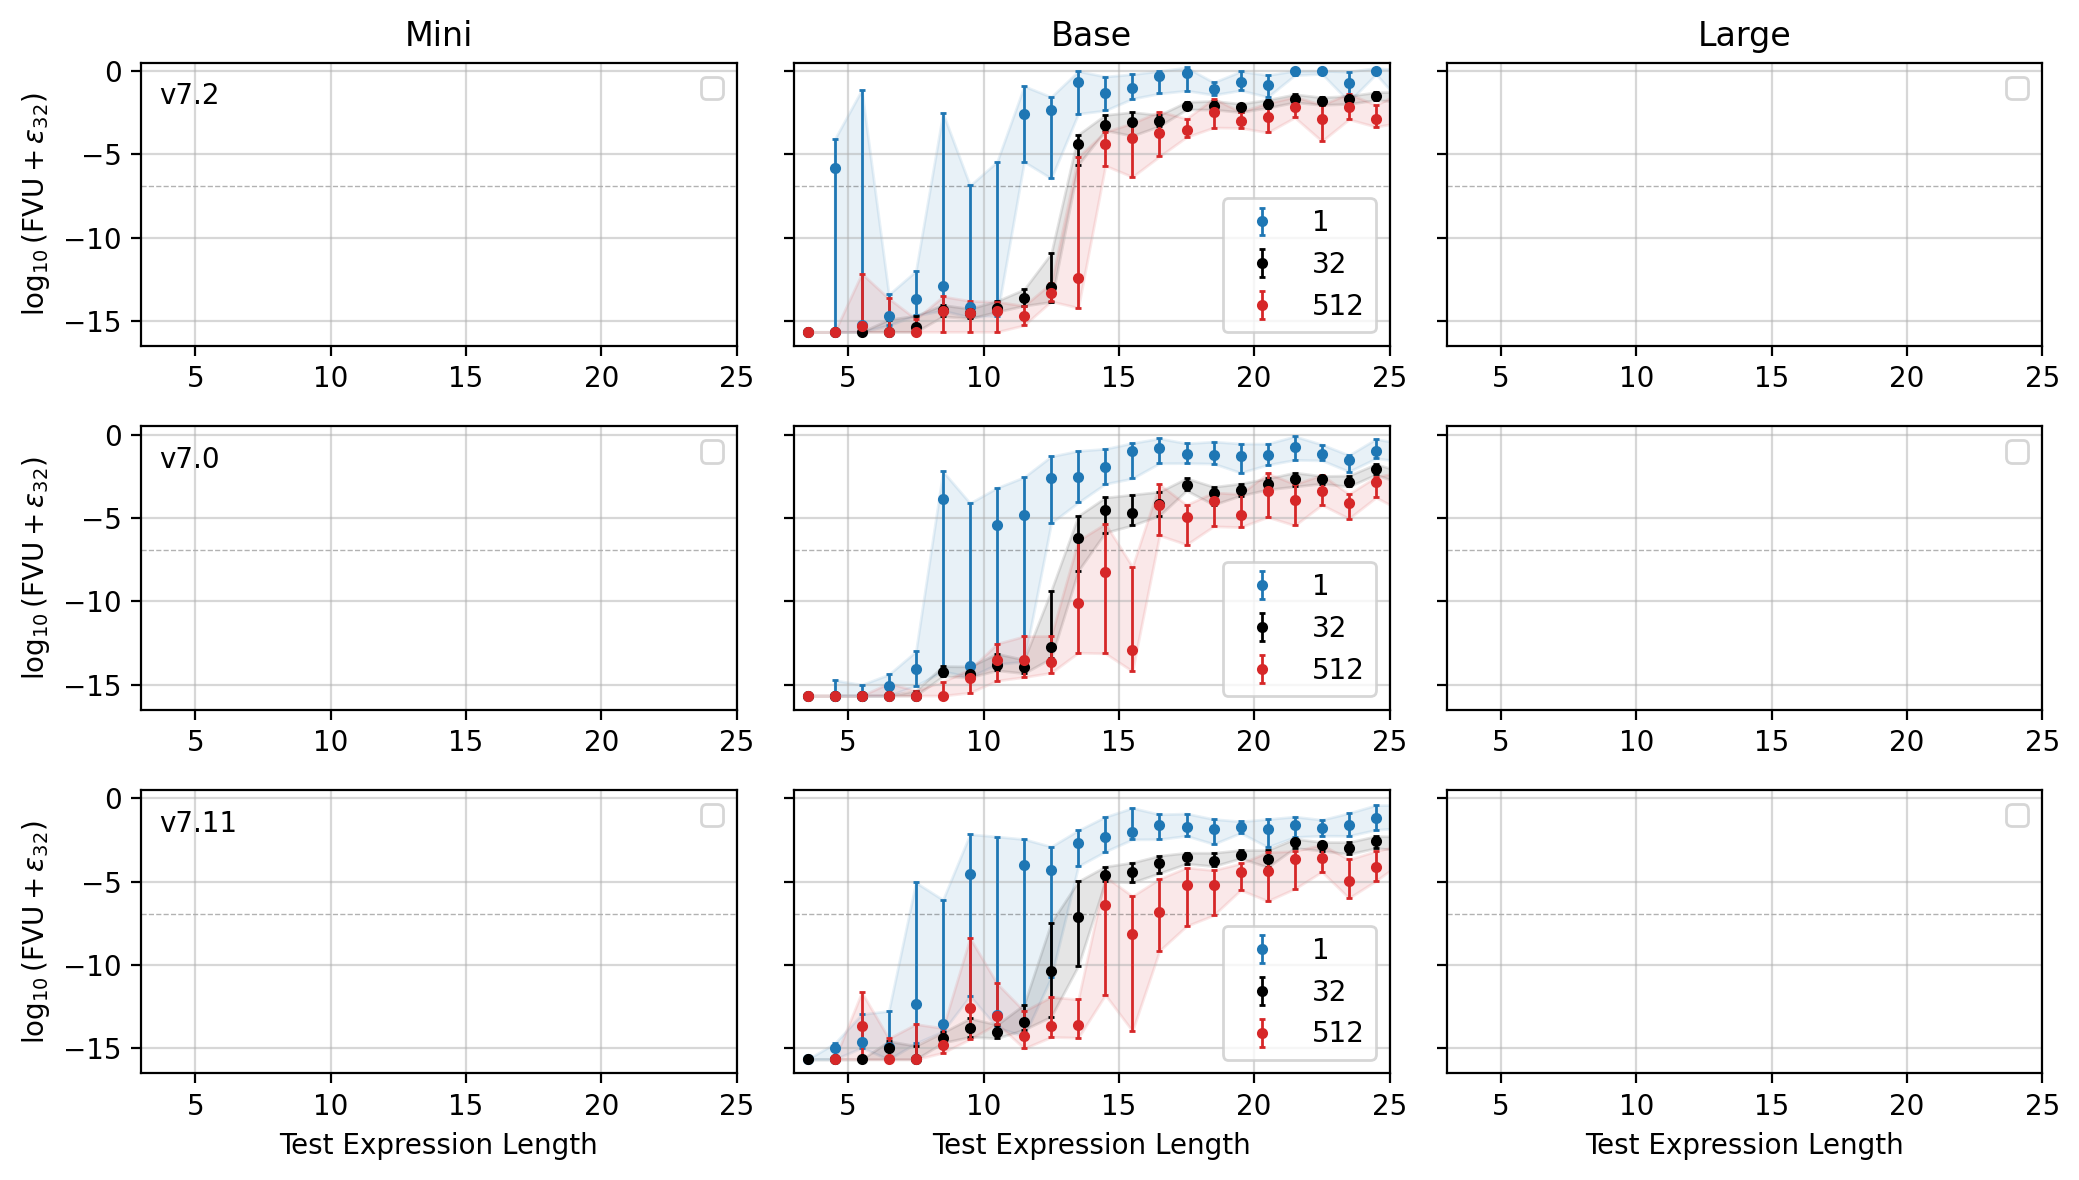

In [25]:
ROWS = 3
COLS = 3

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2), dpi=200, sharex=False, sharey=True)

for r, (axes_row, base_model) in enumerate(zip(axes, ['v7.2', 'v7.0', 'v7.11'])):
    for c, (ax, size, size_name) in enumerate(zip(axes_row, ['-mini', '', '-large'], ['Mini', 'Base', 'Large'])):
        for beam_width, color in zip([1, 32, 512], ['tab:blue', 'k', 'tab:red']):
            if beam_width == 32:
                model = base_model + size
            else:
                model = f'analysis_beams_{base_model}{size}/{base_model}{size}_{beam_width}-beams'

            if not model in fvu_at_lengths:
                continue

            ax.errorbar(
                fvu_at_lengths[model]['pool_15']['index'] + 0.5,
                np.log10(fvu_at_lengths[model]['pool_15']['median']),
                yerr=[
                    np.log10(fvu_at_lengths[model]['pool_15']['median']) - np.log10(fvu_at_lengths[model]['pool_15']['lower']),
                    np.log10(fvu_at_lengths[model]['pool_15']['upper']) - np.log10(fvu_at_lengths[model]['pool_15']['median'])
                ],
                fmt='.', color=color, lw=1, label=beam_width, capsize=1, capthick=1)
            
            # ax.scatter(
            #     fvu_at_lengths[model]['pool_15']['index'] + 0.5,
            #     np.log10(fvu_at_lengths[model]['pool_15']['median']),
            #     marker='.', color=color, lw=0.5, label=beam_width)
            
            # ax.plot(
            #     fvu_at_lengths[model]['pool_15']['index'] + 0.5,
            #     np.log10(fvu_at_lengths[model]['pool_15']['median']),
            #     marker='.', color=color, lw=0.5, label=beam_width)
            ax.fill_between(fvu_at_lengths[model]['pool_15']['index'] + 0.5, np.log10(fvu_at_lengths[model]['pool_15']['lower']), np.log10(fvu_at_lengths[model]['pool_15']['upper']), color=color, alpha=0.1)

        ax.axhline(np.log10(np.finfo(np.float32).eps), color='k', lw=0.5, ls='--', alpha=0.3, zorder=1)
        ax.grid(zorder=0, alpha=0.5)

        if c == 0:
            ax.set_ylabel('$\\log_{10}(\\text{FVU} + \\epsilon_{32})$')
            ax.annotate(base_model, (0.03, 0.93), xycoords='axes fraction', ha='left', va='top')
        if r == ROWS - 1:
            ax.set_xlabel('Test Expression Length')
        if r == 0:
            ax.set_title(size_name)

        ax.set_xlim(3, 25)
        ax.set_ylim(-16.5, 0.5)

        ax.legend()

fig.tight_layout()